<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/autoencoder_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

### 1. Load the MNIST dataset

In [ ]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the tensor with mean and standard deviation of MNIST dataset
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

plotting the dataset

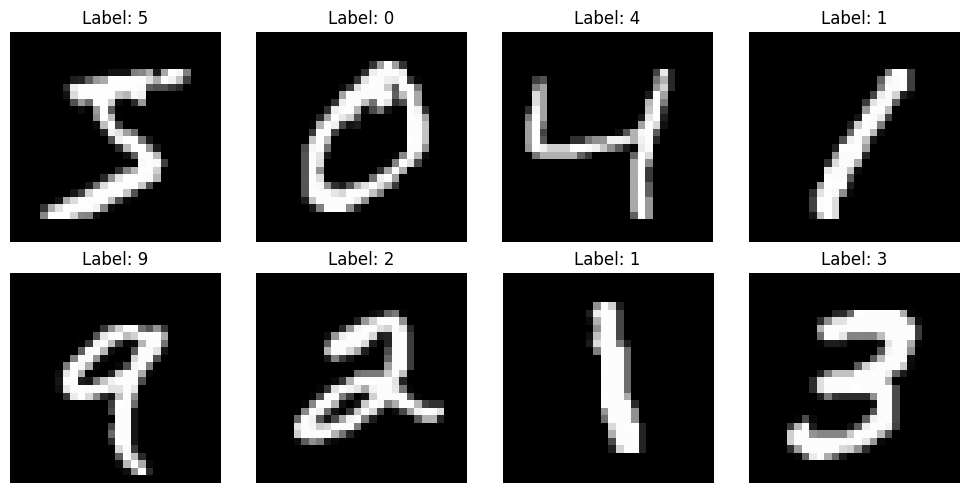

In [ ]:
def plot_images(images, labels, captions, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(captions[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get some sample images and labels from the dataset
sample_images = [train_dataset[i][0].squeeze().numpy() for i in range(8)]
sample_labels = [train_dataset[i][1] for i in range(8)]
sample_captions = [f"Label: {label}" for label in sample_labels]

# Plot the sample images with captions
plot_images(sample_images, sample_labels, sample_captions)

### 2. Create the Dataloaders

In [ ]:
# Define the sizes for train, validation, and test sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_size = len(test_dataset)

In [ ]:
# Split the dataset into train, validation, sets
trn_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# Define batch size for data loaders
batch_size = 100# changed batch size to 100

In [ ]:
# Create data loaders for train, validation, and test sets
train_loader = DataLoader(trn_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 3. Autoencoder model

In [ ]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_linear = nn.Linear(12* 7 * 7, 64*6)

#         # Decoder layers
#         self.decoder_linear = nn.Linear(64*6, 12 * 7 * 7)
#         self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
#         # self.decoder_sigmoid = nn.Sigmoid()

#     def encoder(self, x):
#         # Encoder
#         x = self.encoder_conv1(x)
#         x = self.encoder_maxpool1(x)
#         x = self.encoder_conv2(x)
#         x = self.encoder_maxpool2(x)
#         x = x.view(-1, 12 * 7 * 7)
#         x = self.encoder_linear(x)
#         return x

#     def decoder(self, x):
#         # Decoder
#         x = self.decoder_linear(x)
#         x = x.view(-1, 12, 7, 7)
#         x = self.decoder_conv1(x)
#         x = self.decoder_upsample1(x)
#         x = self.decoder_conv2(x)
#         x = self.decoder_upsample2(x)
#         # x = self.decoder_sigmoid(x)
#         return x

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


In [ ]:
class Autoencoder_simpler(nn.Module):
    def __init__(self):
        super(Autoencoder_simpler, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(12 * 7 * 7, 64)# 64*6 ---> 20

        # Decoder layers
        self.decoder_linear = nn.Linear(64, 12 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 12 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 12, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### training and validation function

In [ ]:
def train_and_evaluate(autoencoder, train_loader, val_loader,
                       num_epochs=10, learning_rate=1e-3, print_epoch=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    autoencoder.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        autoencoder.train()
        for images, _ in train_loader:
            images = images.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        autoencoder.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Move data to device
                outputs = autoencoder(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses

In [ ]:
# Specify the device you want to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def test_model_ae(autoencoder, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    autoencoder.eval()
    criterion = nn.MSELoss()

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct images using the autoencoder
    with torch.no_grad():
        reconstructed_images = autoencoder(images)

    # Move data back to CPU for plotting
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

Training and Testing AE model

In [ ]:
# instantiate the model
# autoencoder=Autoencoder()

# # train
# train_losses, val_losses = train_and_evaluate(autoencoder,
#                                               train_loader, val_loader,
#                                               num_epochs=20, print_epoch=2)

In [ ]:
# instantiate the model
autoencoder_2=Autoencoder_simpler()

# train
train_losses, val_losses = train_and_evaluate(autoencoder_2,
                                              train_loader, val_loader,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.300228832, Val Loss: 0.291599924
Epoch [4/20], Train Loss: 0.279929214, Val Loss: 0.277589674
Epoch [6/20], Train Loss: 0.271407195, Val Loss: 0.269749713
Epoch [8/20], Train Loss: 0.266290568, Val Loss: 0.265360670
Epoch [10/20], Train Loss: 0.262958380, Val Loss: 0.262874678
Epoch [12/20], Train Loss: 0.260341890, Val Loss: 0.260018305
Epoch [14/20], Train Loss: 0.258404252, Val Loss: 0.258581149
Epoch [16/20], Train Loss: 0.256682541, Val Loss: 0.256924306
Epoch [18/20], Train Loss: 0.255162348, Val Loss: 0.255575733
Epoch [20/20], Train Loss: 0.253864458, Val Loss: 0.253898860


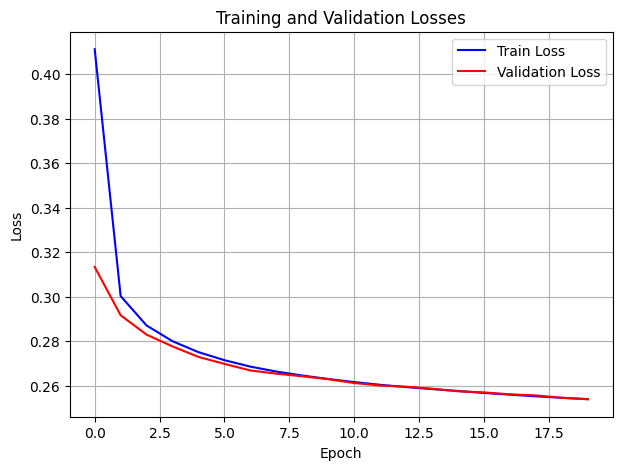

In [ ]:
# Usage example:
plot_losses(train_losses, val_losses)

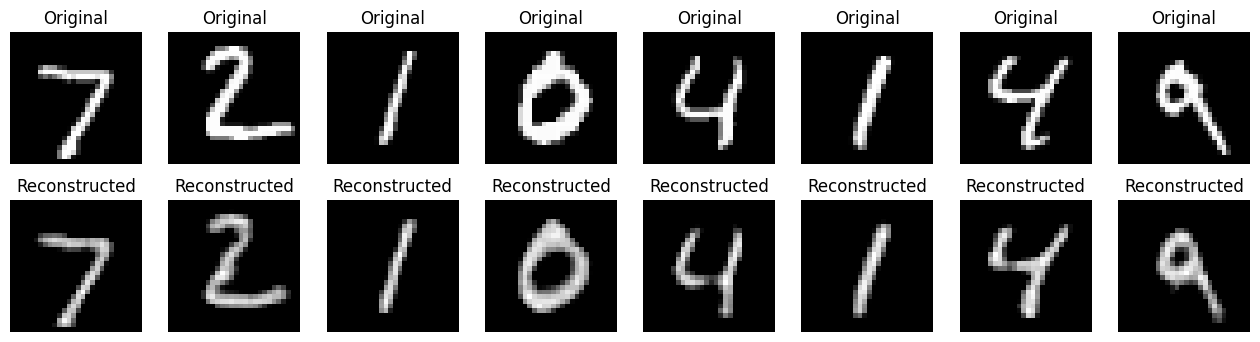

In [ ]:
test_model_ae(autoencoder_2, test_loader)

### Latest conclusion:

Simpler model (`autoencoder_2`) is better than the first model (`autoencoder_1`).

### Tasks to do:

1. FOR SIMPLE MNIST DATASET
    
    ~1.a. try a few more autoencoder models and find out even more good/simple model.~

    ~1.b. Implement the VAE.~

2. FOR COLOURED MNIST DATASET

    2.a. Implement the autoencoder.
  
    2.b. Implement hte VAE

### Variational Autoencoder:

let's try different implementation:


* ref: https://github.com/ludovicobuizza/gan_vae/blob/main/utils.py

* author's medium article: https://ludovico-buizza.medium.com/generating-things-with-vaes-882c6e3b688d

In [ ]:
### new vae MODEL
## SOME UTILS
import torch.nn as nn


def make_module(conv_layer,
                 hyper_params,
                 activation=nn.ReLU):
    modules = []
    in_channels = hyper_params["in_channels"]
    for i in range(len(hyper_params["hidden_channels"])):
        module = nn.Sequential(
            conv_layer(
                in_channels=in_channels,
                out_channels=hyper_params["hidden_channels"][i],
                kernel_size=hyper_params["kernels"][i],
                stride=hyper_params["strides"][i],
                padding=hyper_params["paddings"][i]
            ),
            nn.BatchNorm2d(num_features=hyper_params["hidden_channels"][i]),
            activation(),
        )
        in_channels = hyper_params["hidden_channels"][i]
        modules.append(module)
    return nn.Sequential(*modules)


def make_final_decoder_layer(decoder_hyper_params):
    final_layer = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=decoder_hyper_params["hidden_channels"][-1],
            out_channels=decoder_hyper_params["out_channels"],
            kernel_size=decoder_hyper_params["final_kernel"],
            stride=decoder_hyper_params["final_stride"],
            padding=decoder_hyper_params["final_padding"],
            output_padding=decoder_hyper_params["final_output_padding"],
        ),
        nn.BatchNorm2d(num_features=decoder_hyper_params["out_channels"]),
        nn.LeakyReLU(),
        nn.Conv2d(
            in_channels=decoder_hyper_params["out_channels"],
            out_channels=decoder_hyper_params["out_channels"],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
        #nn.Sigmoid(),
    )
    return final_layer

In [ ]:
class VAE_NEW(nn.Module):
    def __init__(self, encoder_hyper_params, decoder_hyper_params):
        super(VAE_NEW, self).__init__()
        self.latent_dim = encoder_hyper_params["latent_dims"]
        self.encoder_hyper_params = encoder_hyper_params
        self.decoder_hyper_params = decoder_hyper_params

        self.encoder = make_module(
            conv_layer=nn.Conv2d,
            hyper_params=encoder_hyper_params,
            activation=nn.LeakyReLU,
        )
        self.fc_mu = nn.Linear(encoder_hyper_params["fc_neurons"],
                               self.latent_dim)
        self.fc_var = nn.Linear(encoder_hyper_params["fc_neurons"],
                                self.latent_dim)

        last_dim = encoder_hyper_params["hidden_channels"][-1]
        self.decoder_input = nn.Linear(self.latent_dim, last_dim * 4)
        self.decoder = make_module(
            conv_layer=nn.ConvTranspose2d,
            hyper_params=decoder_hyper_params,
            activation=nn.LeakyReLU,
        )
        self.final_layer = make_final_decoder_layer(decoder_hyper_params)

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, int(result.shape[1] / 4), 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        return self.decode(z), mu, log_var

    def generate(self,z):
      # Decoder for generating samples
      return self.decode(z)

    def kl_loss(self, mu, logvar):
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss

In [ ]:
###number of parameters:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## hyperparameters for the encoder and decoder
latent_dims = 12
encoder_hyper_params = {
    "latent_dims": latent_dims,
    "hidden_channels": [24, 24, 24, 24],
    "kernels": [3, 3, 3, 3],
    "strides": [1, 2, 2, 1],
    "paddings": [1, 1, 1, 1],
    "in_channels": 1,
    "fc_neurons": 24 * 49
}

decoder_hyper_params = {
    "in_channels": 24,
    "hidden_channels": [24, 24, 24, 6],
    "kernels": [3, 4, 4, 4],
    "strides": [1, 2, 2, 1],
    "paddings": [0, 0, 0, 0],
    "out_channels": 1,
    "final_kernel": 4,
    "final_stride": 1,
    "final_padding": 0,
    "final_output_padding": 0
}

# Create an instance of VAE_NEW
model = VAE_NEW(encoder_hyper_params=encoder_hyper_params,
            decoder_hyper_params=decoder_hyper_params)

# Count the number of trainable parameters
num_params = count_parameters(model)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 71807


In [ ]:
# import torch
# import torch.nn as nn

# class VAE_SIMPLE(nn.Module):
    # def __init__(self, latent_dim=64*5, dropout_prob=0.2):
    #     super(VAE_SIMPLE, self).__init__()

    #     self.latent_dim = latent_dim  # Define latent_dim as an attribute of the class
    #     print("latent dim:", latent_dim)

    #     # Encoder layers
    #     self.encoder_conv1 = nn.Conv2d(1, 9, kernel_size=4, stride=2, padding=1)
    #     self.encoder_conv2 = nn.Conv2d(9, 18, kernel_size=4, stride=2, padding=1)
    #     self.encoder_linear_hidden = nn.Linear(18 * 7 * 7, 6 * 7 * 7)  # New Linear layer
    #     self.encoder_dropout = nn.Dropout(p=dropout_prob)  # Dropout layer for encoder
    #     self.encoder_linear_mean = nn.Linear(6 * 7 * 7, latent_dim)  # Mean
    #     self.encoder_linear_logvar = nn.Linear(6 * 7 * 7, latent_dim)  # Log variance

    #     # Decoder layers
    #     self.decoder_linear = nn.Linear(latent_dim, 18 * 7 * 7)
    #     self.decoder_dropout = nn.Dropout(p=dropout_prob)  # Dropout layer for decoder
    #     self.decoder_conv1 = nn.ConvTranspose2d(18, 9, kernel_size=4,
    #                                             stride=2, padding=1, output_padding=0)
    #     self.decoder_conv2 = nn.ConvTranspose2d(9, 1, kernel_size=4,
    #                                             stride=2, padding=1, output_padding=0)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    # def encode(self, x):
    #     # Encoder
    #     x = self.encoder_conv1(x)
    #     x = torch.relu(x)
    #     x = self.encoder_conv2(x)
    #     x = torch.relu(x)
    #     x = x.view(-1, 18 * 7 * 7)
    #     x = self.encoder_linear_hidden(x)  # Applying the new linear layer
    #     x = torch.relu(x)
    #     x = self.encoder_dropout(x)  # Apply dropout
    #     mu = self.encoder_linear_mean(x)
    #     logvar = self.encoder_linear_logvar(x)
    #     return mu, logvar

    # def decode(self, z):
    #     # Decoder
    #     x = self.decoder_linear(z)
    #     x = self.decoder_dropout(x)  # Apply dropout
    #     x = x.view(-1, 18, 7, 7)
    #     x = self.decoder_conv1(x)
    #     x = torch.relu(x)
    #     x = self.decoder_conv2(x)
    #     return x

    # def forward(self, x):
    #     mu, logvar = self.encode(x)
    #     z = self.reparameterize(mu, logvar)
    #     x_recon = self.decode(z)
    #     return x_recon, mu, logvar

    # def generate(self, z):
    #     # Decoder for generating samples
    #     return self.decode(z)

    # def kl_loss(self, mu, logvar):
    #     # KL divergence loss
    #     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     return kl_loss

In [ ]:
###number of parameters:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # Create an instance of VAE_SIMPLE
# model = VAE_SIMPLE()

# # Count the number of trainable parameters
# num_params = count_parameters(model)
# print("Number of trainable parameters:", num_params)


latent dim: 320
Number of trainable parameters: 737033


In [ ]:
# import torch.nn.functional as F

# class VAE_FC(nn.Module):
    # def __init__(self, input_dim=784, latent_dim=20, dropout_prob=0.2):
    #     super(VAE_FC, self).__init__()

    #     self.input_dim = input_dim
    #     self.latent_dim = latent_dim
    #     self.dropout_prob = dropout_prob

    #     # Encoder layers
    #     self.encoder_fc1 = nn.Linear(input_dim, 512)
    #     self.encoder_dropout1 = nn.Dropout(p=dropout_prob)
    #     self.encoder_fc2_mean = nn.Linear(512, latent_dim)  # Mean
    #     self.encoder_fc2_logvar = nn.Linear(512, latent_dim)  # Log variance

    #     # Decoder layers
    #     self.decoder_fc1 = nn.Linear(latent_dim, 512)
    #     self.decoder_dropout1 = nn.Dropout(p=dropout_prob)
    #     self.decoder_fc2 = nn.Linear(512, input_dim)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    # def encode(self, x):
    #     x = torch.relu(self.encoder_fc1(x))
    #     x = self.encoder_dropout1(x)
    #     mu = self.encoder_fc2_mean(x)
    #     logvar = self.encoder_fc2_logvar(x)
    #     return mu, logvar

    # def decode(self, z):
    #     z = torch.relu(self.decoder_fc1(z))
    #     z = self.decoder_dropout1(z)
    #     recon_x = self.decoder_fc2(z) #torch.sigmoid(self.decoder_fc2(z))
    #     return recon_x.view(-1,1,28,28)

    # def forward(self, x):
    #     # Flatten input
    #     x = x.view(-1, self.input_dim)
    #     # Encode
    #     mu, logvar = self.encode(x)
    #     # Reparameterize
    #     z = self.reparameterize(mu, logvar)
    #     # Decode
    #     recon_x = self.decode(z)
    #     return recon_x, mu, logvar

    # def kl_loss(self, mu, logvar):
    #     # KL divergence loss
    #     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     return kl_loss

    # def generate(self, z):
    #     self.eval()  # Set model to evaluation mode
    #     with torch.no_grad():
    #         # Decode latent vectors to generate images
    #         generated_images = self.decode(z).cpu()

    #         return generated_images

In [ ]:
# Create an instance of VAE_SIMPLE
# model_vae_fc = VAE_FC()

# # Count the number of trainable parameters
# num_params = count_parameters(model_vae_fc)
# print("Number of trainable parameters:", num_params)

Number of trainable parameters: 835384


In [ ]:
# def train_and_evaluate_vae(vae, train_loader, val_loader,
#                            num_epochs=10, learning_rate=1e-3, print_epoch=10,
#                            wt_kl=0.0001,
#                            device='cuda' if torch.cuda.is_available() else 'cpu'):


#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(vae.parameters(), lr=learning_rate
#                            ,weight_decay=1e-5)

#     vae.to(device)  # Move model to device

#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         train_loss = 0.0
#         val_loss = 0.0

#         # Training
#         vae.train()
#         for images, _ in train_loader:
#             images = images.to(device)  # Move data to device
#             optimizer.zero_grad()
#             recon_images, mu, logvar = vae(images)
#             recon_loss = criterion(recon_images, images)
#             kl_loss = vae.kl_loss(mu, logvar)
#             loss = recon_loss + wt_kl*kl_loss
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         # Validation
#         vae.eval()
#         with torch.no_grad():
#             for images, _ in val_loader:
#                 images = images.to(device)  # Move data to device
#                 recon_images, mu, logvar = vae(images)
#                 recon_loss = criterion(recon_images, images)
#                 kl_loss = vae.kl_loss(mu, logvar)
#                 loss = recon_loss +  wt_kl*kl_loss
#                 val_loss += loss.item()

#         # Average losses
#         train_loss /= len(train_loader.dataset)
#         val_loss /= len(val_loader.dataset)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         # Print losses
#         if (epoch + 1) % print_epoch == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

#     return train_losses, val_losses


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_and_evaluate_vae(vae, train_loader, val_loader,
                           num_epochs=10, learning_rate=1e-3, print_epoch=10,
                           wt_kl=0.0001,
                           device='cuda' if torch.cuda.is_available() else 'cpu'):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        vae.train()
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch', leave=False) as pbar:
            for images, _ in train_loader:
                images = images.to(device)  # Move data to device
                optimizer.zero_grad()
                recon_images, mu, logvar = vae(images)
                recon_loss = criterion(recon_images, images)
                kl_loss = vae.kl_loss(mu, logvar)
                loss = recon_loss + wt_kl * kl_loss
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                pbar.update(1)

        # Validation
        vae.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Move data to device
                recon_images, mu, logvar = vae(images)
                recon_loss = criterion(recon_images, images)
                kl_loss = vae.kl_loss(mu, logvar)
                loss = recon_loss + wt_kl * kl_loss
                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses


In [ ]:
def test_model_vae(vae, test_loader,
                   device='cuda' if torch.cuda.is_available() else 'cpu'):
    vae.eval()
    criterion = nn.MSELoss(reduction = 'sum')

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct images using the VAE
    with torch.no_grad():
        reconstructed_images, _, _ = vae(images)

    # Move data back to CPU for plotting
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

In [ ]:
def plot_generated_images_vae(vae, num_samples=10,
                              device='cuda' if torch.cuda.is_available() else 'cpu'):
    vae.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # # Generate samples from the latent space
        z = torch.randn(num_samples, vae.latent_dim).to(device)
        generated_images = vae.generate(z).cpu()

        # Plot generated images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            axes[i].imshow(generated_images[i][0], cmap='gray')
            axes[i].axis('off')
        plt.show()

Train and Test VAE model

In [ ]:
## hyperparameters for the encoder and decoder
latent_dims = 12
encoder_hyper_params = {
    "latent_dims": latent_dims,
    "hidden_channels": [24, 24, 24, 24],
    "kernels": [3, 3, 3, 3],
    "strides": [1, 2, 2, 1],
    "paddings": [1, 1, 1, 1],
    "in_channels": 1,
    "fc_neurons": 24 * 49# 24*7*7
}

decoder_hyper_params = {
    "in_channels": 24,
    "hidden_channels": [24, 24, 24, 6],
    "kernels": [3, 4, 4, 4],
    "strides": [1, 2, 2, 1],
    "paddings": [0, 0, 0, 0],
    "out_channels": 1,
    "final_kernel": 4,
    "final_stride": 1,
    "final_padding": 0,
    "final_output_padding": 0
}

# Create an instance of VAE_NEW
vae_new= VAE_NEW(encoder_hyper_params=encoder_hyper_params,
            decoder_hyper_params=decoder_hyper_params)

In [ ]:
# print(vae_new)

In [ ]:
### train the model
train_losses_vae, val_losses_vae = train_and_evaluate_vae(vae_new,
                                              train_loader, val_loader,learning_rate=1e-3,
                                              num_epochs=10, print_epoch=2)

Epoch [2/10], Train Loss: 0.007835401, Val Loss: 0.007087212


Epoch [4/10], Train Loss: 0.005424858, Val Loss: 0.004995223


Epoch [6/10], Train Loss: 0.004201218, Val Loss: 0.003994157


Epoch [8/10], Train Loss: 0.003680350, Val Loss: 0.003628861


Epoch [10/10], Train Loss: 0.003501015, Val Loss: 0.003466723


In [ ]:
# instantiate the model
# vae_simple=VAE_SIMPLE(dropout_prob=0.1)

# # train
# train_losses_vae, val_losses_vae = train_and_evaluate_vae(vae_simple,
#                                               train_loader, val_loader,learning_rate=2e-3,
#                                               num_epochs=50, print_epoch=2)

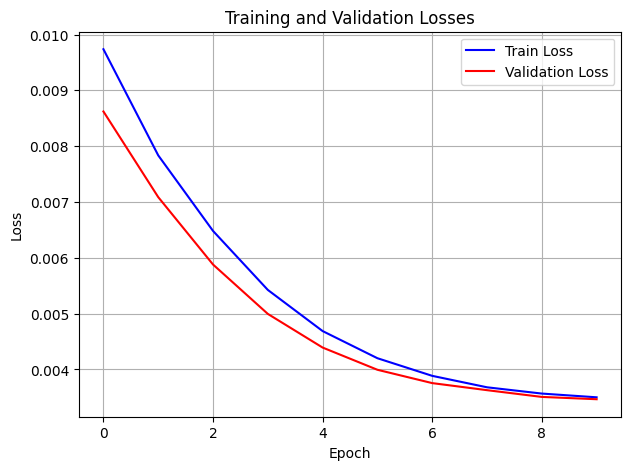

In [ ]:
plot_losses(train_losses_vae[:], val_losses_vae[:])

testing VAE fully connected model

In [ ]:
# instantiate the model
# vae_fc=VAE_FC()

# # train
# train_losses_vae_fc, val_losses_vae_fc = train_and_evaluate_vae(vae_fc,
#                                               train_loader, val_loader,learning_rate=2e-3,
#                                               num_epochs=10, print_epoch=2)

Epoch [2/10], Train Loss: 0.004756056, Val Loss: 0.004401714
Epoch [4/10], Train Loss: 0.004635823, Val Loss: 0.004263272
Epoch [6/10], Train Loss: 0.004596372, Val Loss: 0.004300199
Epoch [8/10], Train Loss: 0.004570009, Val Loss: 0.004221826
Epoch [10/10], Train Loss: 0.004552611, Val Loss: 0.004273179


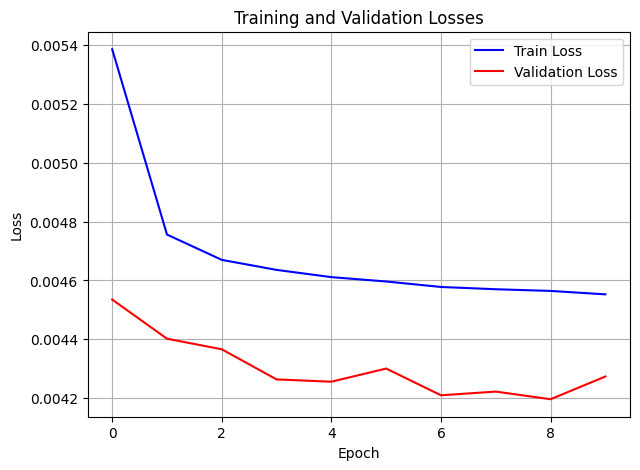

In [ ]:
# plot_losses(train_losses_vae_fc[:], val_losses_vae_fc[:])

reconstruction using VAE

with CNN based VAE_NEW


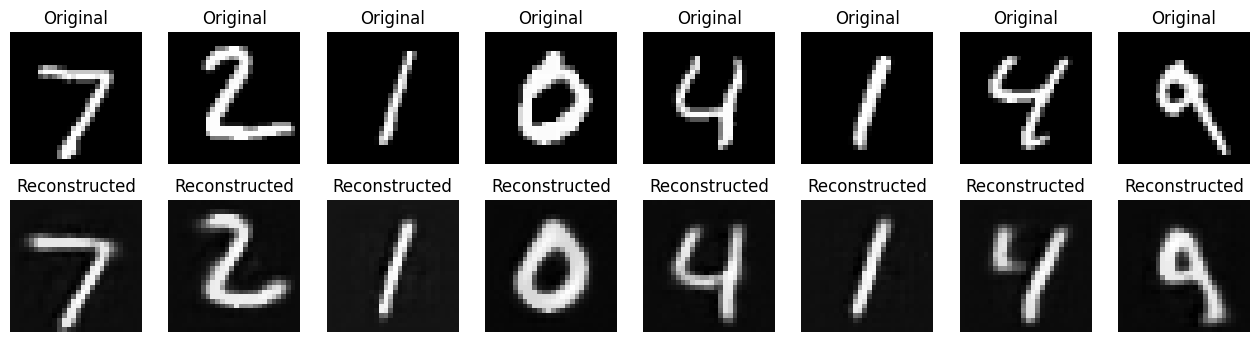

In [ ]:
print("with CNN based VAE_NEW")
test_model_vae(vae_new, test_loader)

with CNN based VAE


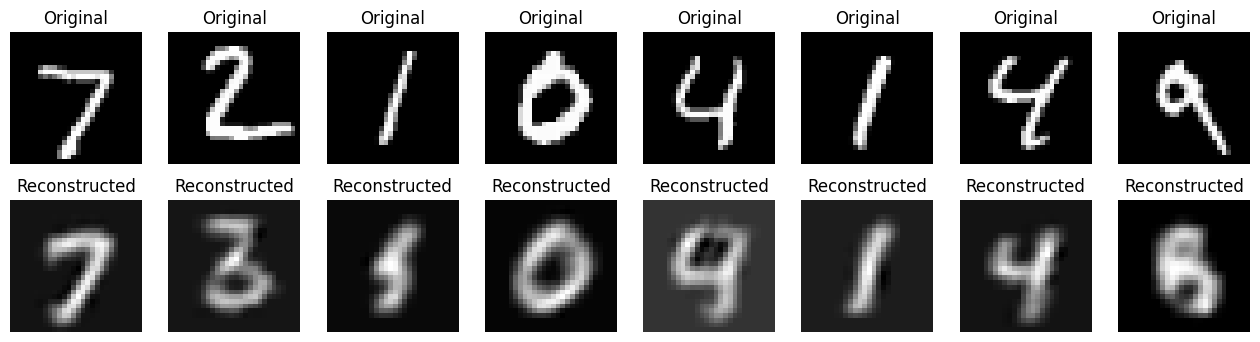

In [ ]:
# print("with CNN based VAE")
# test_model_vae(vae_simple, test_loader)

with CNN based VAE-50 epochs of training


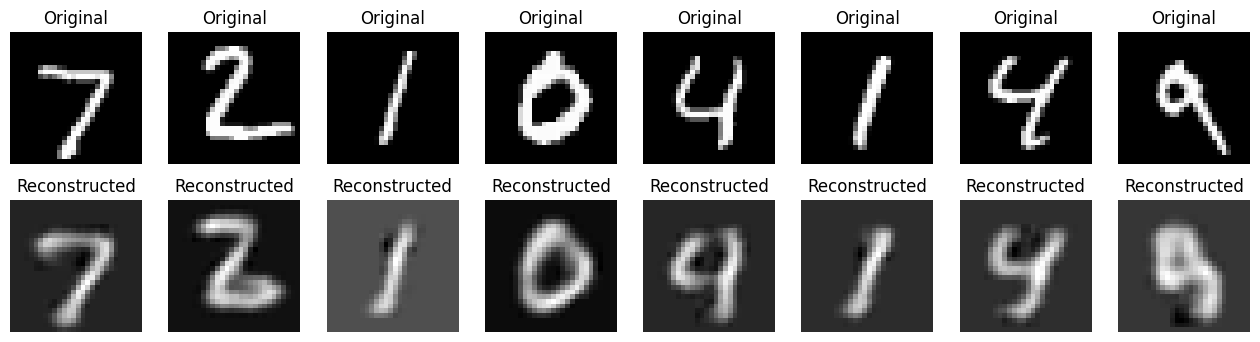

In [ ]:
# print("with CNN based VAE-50 epochs of training")
# test_model_vae(vae_simple, test_loader)

VAE_FC


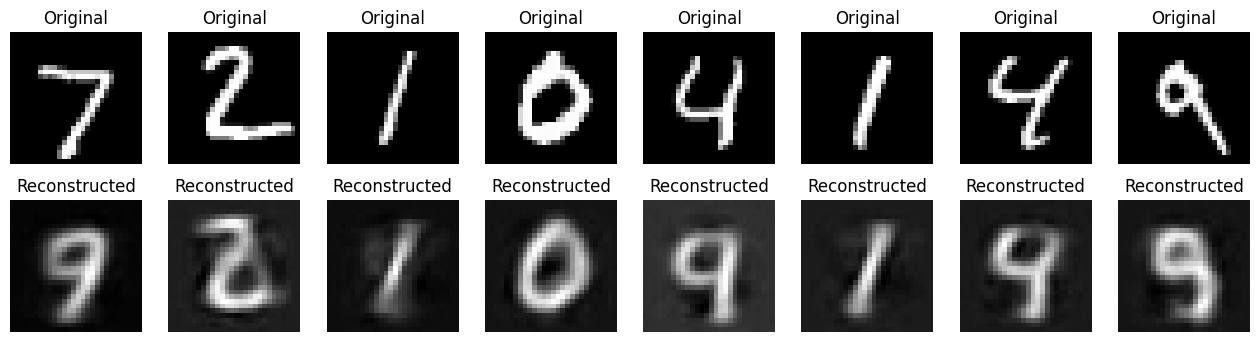

In [ ]:
# testing vae with FC
# print("VAE_FC")
# test_model_vae(vae_fc, test_loader)

generating images using VAE

VAE-new


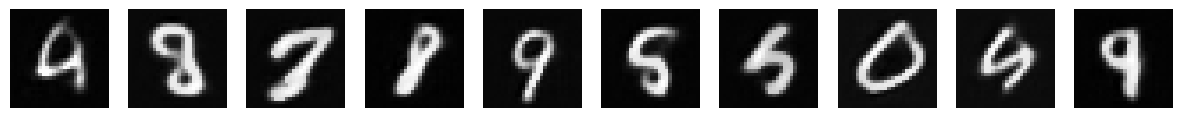

In [ ]:
print("VAE-new")
plot_generated_images_vae(vae_new)

VAE-CNN based


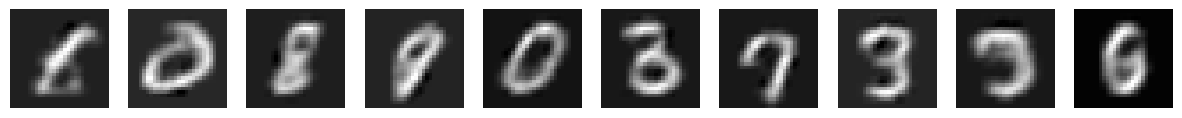

In [ ]:
# print("VAE-CNN based")
# plot_generated_images_vae(vae_simple)

VAE-CNN based-after 50 epochs:


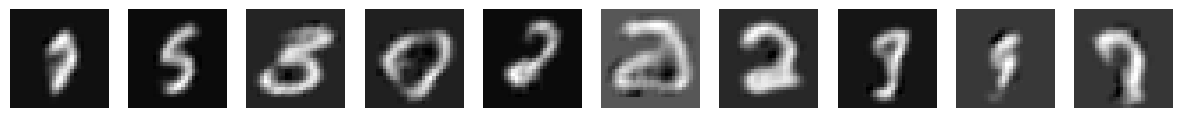

In [ ]:
# print("VAE-CNN based-after 50 epochs:")
# plot_generated_images_vae(vae_simple)

VAE- FC


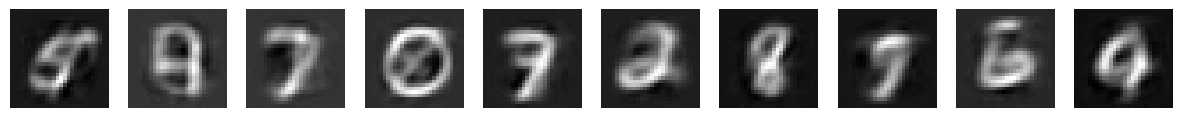

In [ ]:
# testing quality of generated images with vae_fc
# print("VAE- FC")
# plot_generated_images_vae(vae_fc)

# checking something.



In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.datasets import MNIST
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_linear = nn.Linear(32 * 7 * 7, 64)

#         # Decoder layers
#         self.decoder_linear = nn.Linear(64, 32 * 7 * 7)
#         self.decoder_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Encoder
#         print("image shape at the beginning:", x.shape)
#         x = self.encoder_conv1(x)
#         print("Shape after encoder_conv1:", x.shape)
#         x = self.encoder_maxpool1(x)
#         print("Shape after encoder_maxpool1:", x.shape)
#         x = self.encoder_conv2(x)
#         print("Shape after encoder_conv2:", x.shape)
#         x = self.encoder_maxpool2(x)
#         print("Shape after encoder_maxpool2:", x.shape)
#         x = x.view(-1, 32 * 7 * 7)
#         print("Shape after flattening:", x.shape)
#         x = self.encoder_linear(x)
#         print("Shape after encoder_linear:", x.shape)

#         print("encoder finished now decoder")

#         # Decoder
#         x = self.decoder_linear(x)
#         print("Shape after decoder_linear:", x.shape)
#         x = x.view(-1, 32, 7, 7)
#         print("Shape after reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("Shape after decoder_conv1:", x.shape)
#         x = self.decoder_upsample1(x)
#         print("Shape after decoder_upsample1:", x.shape)
#         x = self.decoder_conv2(x)
#         print("Shape after decoder_conv2:", x.shape)
#         x = self.decoder_upsample2(x)
#         print("Shape after decoder_upsample2:", x.shape)

#         return x

# # Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Create an instance of the autoencoder
# autoencoder = Autoencoder()

# # Take one image from the dataset
# x, _ = next(iter(train_loader))
# image = x[0].unsqueeze(0)  # Take the first image from the batch and add a batch dimension

# # Forward pass through the autoencoder with the image
# output = autoencoder(image)


In [ ]:
# class VAE_SIMPLE(nn.Module):
#     def __init__(self, latent_dim=128):
#         super(VAE_SIMPLE, self).__init__()

#         self.latent_dim= latent_dim #Define latent_dim as an attribute of the class
#         print("latent dim:", latent_dim)

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=4, stride=2, padding=1)
#         self.encoder_linear_mean = nn.Linear(12 * 7 * 7, latent_dim)  # Mean
#         self.encoder_linear_logvar = nn.Linear(12 * 7 * 7, latent_dim)  # Log variance

#         # Decoder layers
#         self.decoder_linear = nn.Linear(latent_dim, 12 * 7 * 7)  # Must match the output shape of the encoder_linear layers
#         self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=4,
#                                                 stride=2, padding=1, output_padding=0)  # Must match the output shape of encoder_conv2
#         self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=4,
#                                                 stride=2, padding=1, output_padding=0)  # Must match the output shape of encoder_conv1


#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         # Encoder
#         x = self.encoder_conv1(x)
#         print("After encoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.encoder_conv2(x)
#         print("After encoder_conv2:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = x.view(-1, 12 * 7 * 7)
#         print("After flattening:", x.shape)
#         mu = self.encoder_linear_mean(x)
#         print("Mean shape:", mu.shape)
#         logvar = self.encoder_linear_logvar(x)
#         print("Logvar shape:", logvar.shape)
#         z = self.reparameterize(mu, logvar)

#         # Decoder
#         x = self.decoder_linear(z)
#         print("After decoder_linear:", x.shape)
#         x = x.view(-1, 12, 7, 7)
#         print("After reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("After decoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.decoder_conv2(x)
#         print("After decoder_conv2:", x.shape)
#         #x = torch.sigmoid(x)  # Use sigmoid activation for output in [0, 1]

#         return x, mu, logvar

#     def generate(self, z):

#         # Generate samples from the standard normal distribution
#         #z = torch.randn(batch_size, self.latent_dim).to(device)
#         # Decoder for generating samples
#         x = self.decoder_linear(z)
#         print("After decoder_linear:", x.shape)
#         x = x.view(-1, 12, 7, 7)
#         print("After reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("After decoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.decoder_conv2(x)
#         print("After decoder_conv2:", x.shape)
#         #x = torch.sigmoid(x)  # Use sigmoid activation for output in [0, 1]

#         return x

#     def kl_loss(self, mu, logvar):
#         # KL divergence loss
#         kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         return kl_loss

# # # Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Create an instance of the autoencoder
# vae = VAE_SIMPLE()

# # Take one image from the dataset
# x, _ = next(iter(train_loader))
# image = x[0].unsqueeze(0)  # Take the first image from the batch and add a batch dimension

# # Forward pass through the autoencoder with the image
# output = vae(image)
